In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [21]:
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

In [22]:
df_1 = pd.read_csv("2015.csv")
df_2 = pd.read_csv("2016.csv")
df_3 = pd.read_csv("2017.csv")
df_4 = pd.read_csv("2018.csv")
df_5 = pd.read_csv("2019.csv")

In [23]:
common_cols = ['Country', 'Happiness Score', 'Economy (GDP per Capita)',
               'Family', 'Health (Life Expectancy)', 'Freedom', 'Generosity',
               'Trust (Government Corruption)']

In [24]:
rename_dict = {
    'Social support': 'Family',
    'Trust..Government.Corruption.': 'Trust (Government Corruption)',
    'Perceptions of corruption': 'Trust (Government Corruption)',
    'Country or region': 'Country',
    'Overall rank': 'Happiness Rank',
    'Score': 'Happiness Score',
    'GDP per capita': 'Economy (GDP per Capita)',
    'Healthy life expectancy': 'Health (Life Expectancy)'
}

In [25]:
df_1 = df_1.rename(columns=rename_dict)
df_2 = df_2.rename(columns=rename_dict)
df_3 = df_3.rename(columns=rename_dict)
df_4 = df_4.rename(columns=rename_dict)
df_5 = df_5.rename(columns=rename_dict)

In [26]:
def select_common(df, cols):
    available = ['Country'] + [c for c in cols[1:] if c in df.columns]
    return df[available].copy()

dfs = [select_common(df, common_cols) for df in [df_1, df_2, df_3, df_4, df_5]]

In [27]:
for i, df in enumerate(dfs):
    df['Year'] = 2015 + i

df_combined = pd.concat(dfs, ignore_index=True)

In [28]:
print(f" total records: {len(df_combined)}")
print(f" number of countries: {df_combined['Country'].nunique()}")
print(" final columns:")
print(df_combined.columns.tolist())

 total records: 782
 number of countries: 170
 final columns:
['Country', 'Happiness Score', 'Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)', 'Freedom', 'Generosity', 'Trust (Government Corruption)', 'Year']


In [29]:
feature_cols = ['Economy (GDP per Capita)', 'Family',
                'Health (Life Expectancy)', 'Freedom', 'Generosity',
                'Trust (Government Corruption)']

In [30]:
for col in feature_cols:
    if col in df_combined.columns:
        df_combined[col] = df_combined.groupby('Country')[col].transform(
            lambda x: x.fillna(x.mean() if not x.mean() is np.nan else df_combined[col].mean())
        )

In [31]:
df_combined[feature_cols] = df_combined[feature_cols].fillna(df_combined[feature_cols].mean())

X = df_combined[feature_cols].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [32]:
inertias = []
sil_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, kmeans.labels_))

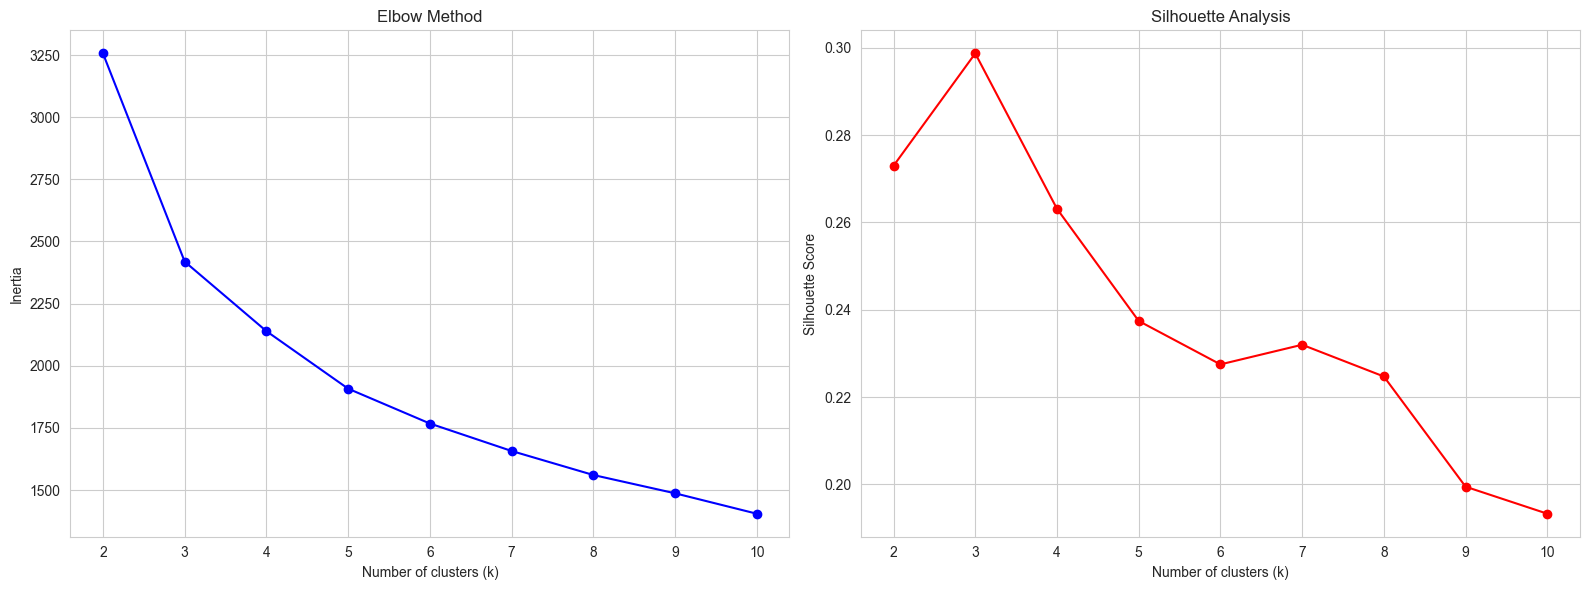

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')
ax1.grid(True)
ax2.plot(K_range, sil_scores, 'ro-')
ax2.set_xlabel('Number of clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [34]:
best_k = K_range[np.argmax(sil_scores)]
print(f"\n the best number of clusters by Silhouette Score: {best_k}")

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
df_combined['Cluster'] = clusters


 the best number of clusters by Silhouette Score: 3


In [35]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

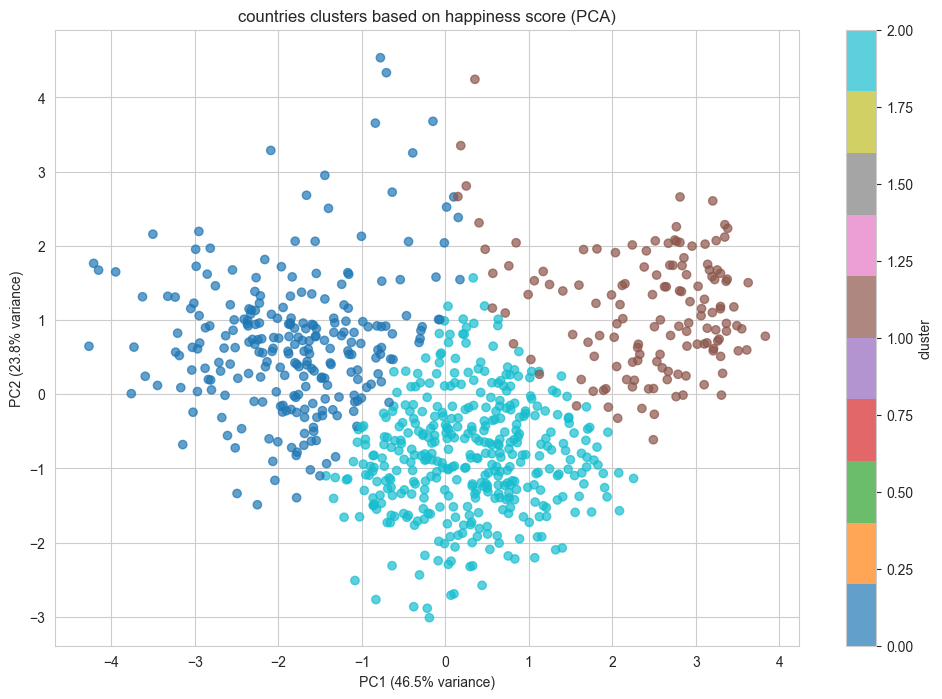

In [36]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10', alpha=0.7)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('countries clusters based on happiness score (PCA)')
plt.colorbar(scatter, label='cluster')
plt.grid(True)
plt.show()

In [37]:
cluster_summary = df_combined.groupby('Cluster')[feature_cols].mean()
cluster_summary['Count'] = df_combined['Cluster'].value_counts()

print("\n features mean in each cluster:")
print(cluster_summary)
print(cluster_summary.round(3))


 features mean in each cluster:
         Economy (GDP per Capita)    Family  Health (Life Expectancy)  \
Cluster                                                                 
0                        0.449991  0.761459                  0.344055   
1                        1.322465  1.330138                  0.842459   
2                        1.031893  1.190229                  0.728937   

          Freedom  Generosity  Trust (Government Corruption)  Count  
Cluster                                                              
0        0.330464    0.237112                       0.106837    249  
1        0.574991    0.342277                       0.292314    138  
2        0.388558    0.163674                       0.079330    395  
         Economy (GDP per Capita)  Family  Health (Life Expectancy)  Freedom  \
Cluster                                                                        
0                           0.450   0.761                     0.344    0.330   
1          

In [38]:
cluster_names = {
    0: "Unhappy countries",
    1: "Happy countries",
    2: "Usual countries",
}

print("\n countries in each cluster:")
print(cluster_names)
for cluster in sorted(df_combined['Cluster'].unique()):
    countries = df_combined[df_combined['Cluster'] == cluster]['Country'].unique()[:]
    print(f"cluster {cluster}: {', '.join(countries)}")




 countries in each cluster:
{0: 'Unhappy countries', 1: 'Happy countries', 2: 'Usual countries'}
cluster 0: Kosovo, Nigeria, Pakistan, Zambia, Somaliland region, Morocco, Mozambique, Lesotho, Laos, Swaziland, Tajikistan, Bangladesh, Iran, Iraq, Ghana, Zimbabwe, Liberia, India, Sudan, Haiti, Congo (Kinshasa), Nepal, Ethiopia, Sierra Leone, Mauritania, Kenya, Djibouti, Botswana, Myanmar, Georgia, Malawi, Cameroon, Yemen, Angola, Mali, Congo (Brazzaville), Comoros, Uganda, Senegal, Niger, Cambodia, Tanzania, Madagascar, Central African Republic, Chad, Guinea, Ivory Coast, Burkina Faso, Afghanistan, Benin, Syria, Burundi, Togo, Guatemala, Nicaragua, Belize, Moldova, Bolivia, Somalia, Indonesia, Philippines, Bhutan, Kyrgyzstan, Bosnia and Herzegovina, Somaliland Region, Tunisia, Honduras, Palestinian Territories, Namibia, South Africa, Sri Lanka, Egypt, Armenia, Gabon, South Sudan, Rwanda, Gambia
cluster 1: Switzerland, Iceland, Denmark, Norway, Canada, Finland, Netherlands, Sweden, New Ze